# *Title**

# Introduction

test

# Preliminary Results

In [122]:
#install.packages("tidymodels")


In [2]:
library(tidyverse)
library(tidymodels)
options(repr.plot.width = 10, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

In [3]:
# Grabbing the data
url <- "https://gist.githubusercontent.com/zhonglism/f146a9423e2c975de8d03c26451f841e/raw/f79e190df4225caed58bf360d8e20a9fa872b4ac/vgsales.csv"
#Reading data into R
gaming_dataset <- read_csv(url)
#Selecting columns we need for our analysis
gaming_data <- gaming_dataset %>%
filter(
Year > 2001,
Global_Sales > 1) %>%
select(Platform, NA_Sales, JP_Sales, Global_Sales) |>
  mutate(Platform = if_else(Platform %in% c("DS", "GBA", "GB", "PSV", "PSP"), "Handheld", "Home Console"))

gaming_data

Rows: 16598 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Platform, Year, Genre, Publisher
dbl (6): Rank, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Platform,NA_Sales,JP_Sales,Global_Sales
<chr>,<dbl>,<dbl>,<dbl>
Home Console,41.49,3.77,82.74
Home Console,15.85,3.79,35.82
Home Console,15.75,3.28,33.00
⋮,⋮,⋮,⋮
Home Console,0.33,0.02,1.01
Home Console,0.27,0.00,1.01
Home Console,0.21,0.00,1.01


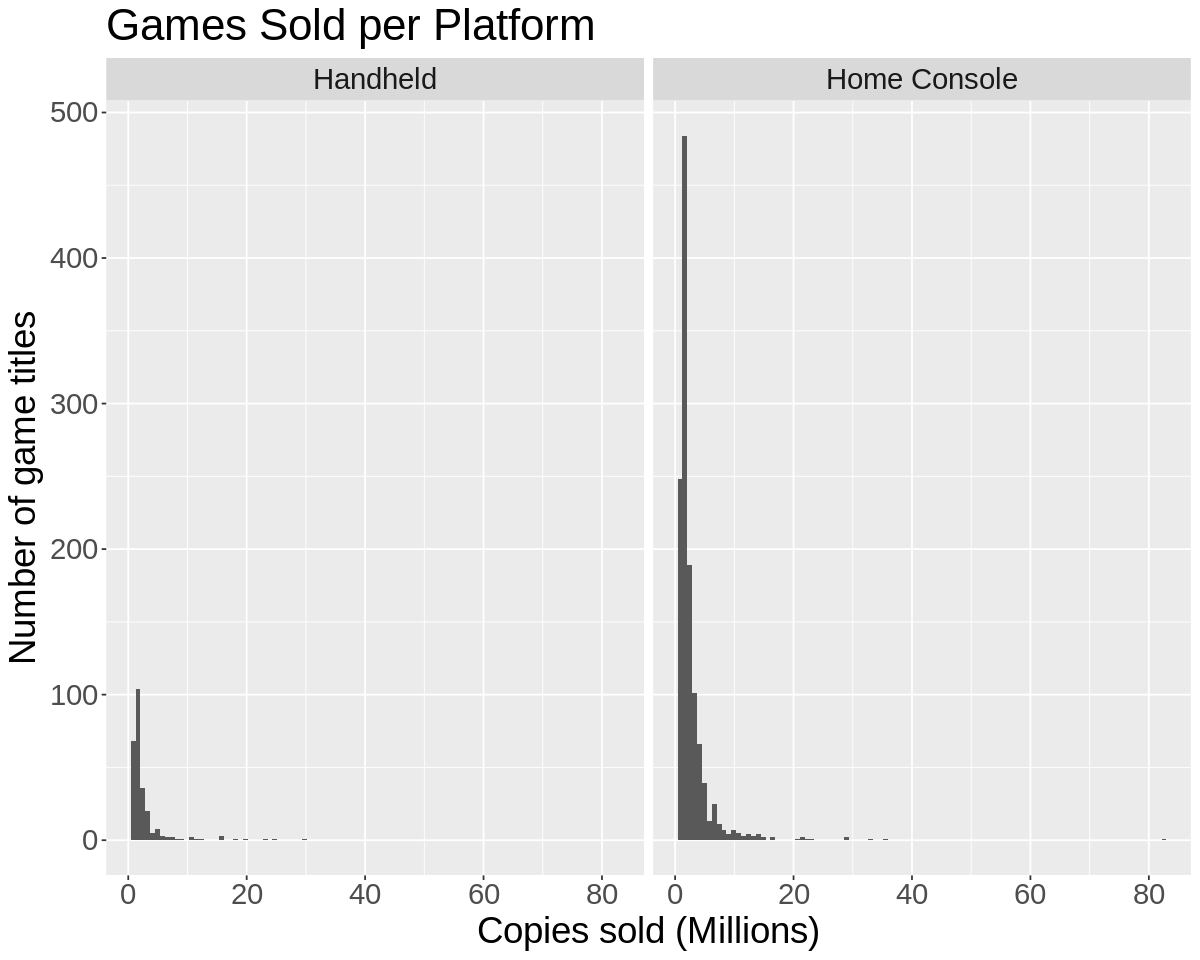

In [134]:
#Comparing the sampling distributions of handheld and home console systems globally
gaming_data_dist_global <-
gaming_data %>%
ggplot() +
geom_histogram(aes(x = Global_Sales), bins = 100) +
facet_wrap(~ Platform) +
xlab("Copies sold (Millions)") +
ylab("Number of game titles") +
ggtitle("Games Sold per Platform")+
theme(text = element_text(size = 22))
gaming_data_dist_global

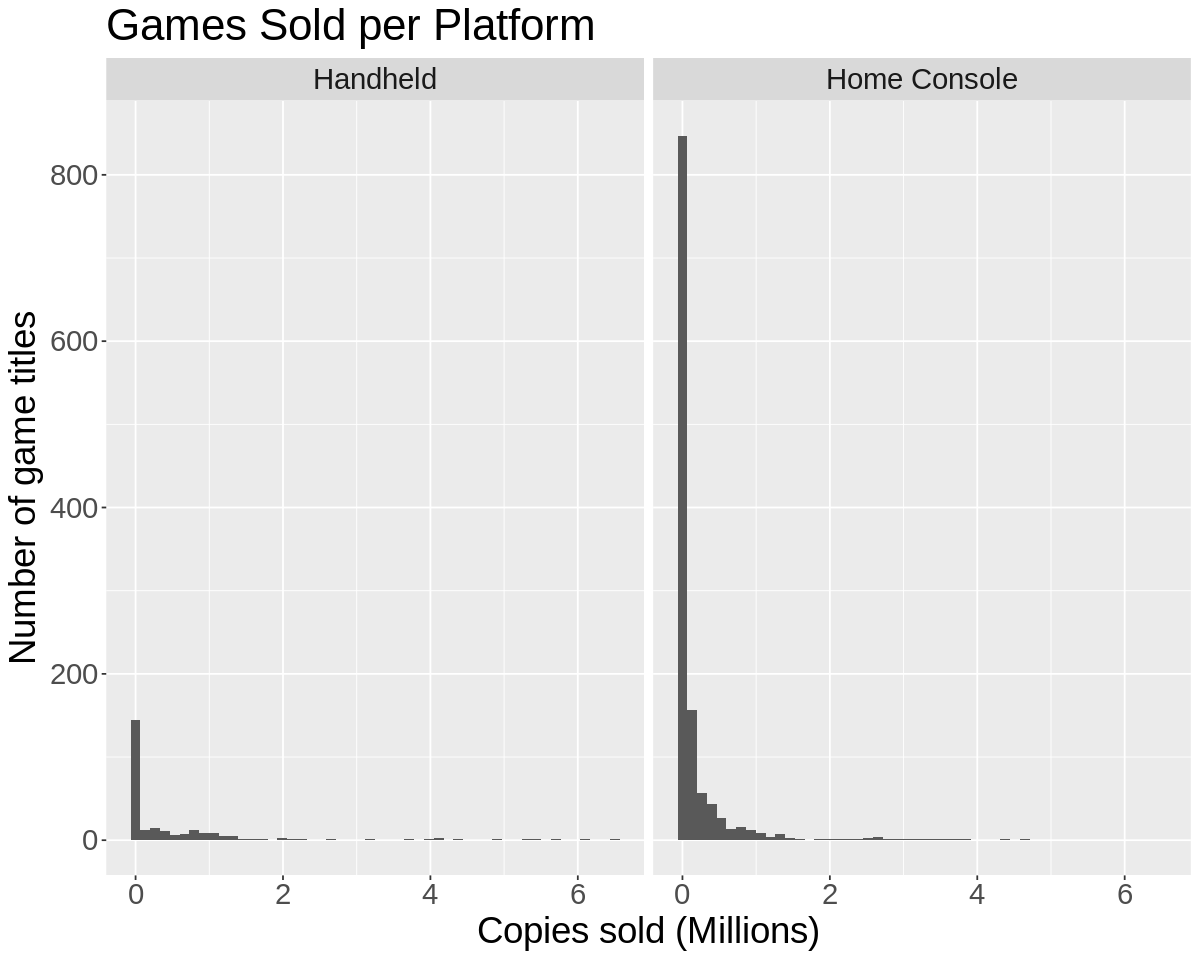

In [135]:
#Comparing the sampling distributions of handheld and home console systems in Japan
gaming_data_dist_jp <-
gaming_data %>%
ggplot() +
geom_histogram(aes(x = JP_Sales), bins = 50) +
facet_wrap(~ Platform) +
xlab("Copies sold (Millions)") +
ylab("Number of game titles") +
ggtitle("Games Sold per Platform")+
theme(text = element_text(size = 22))
gaming_data_dist_jp

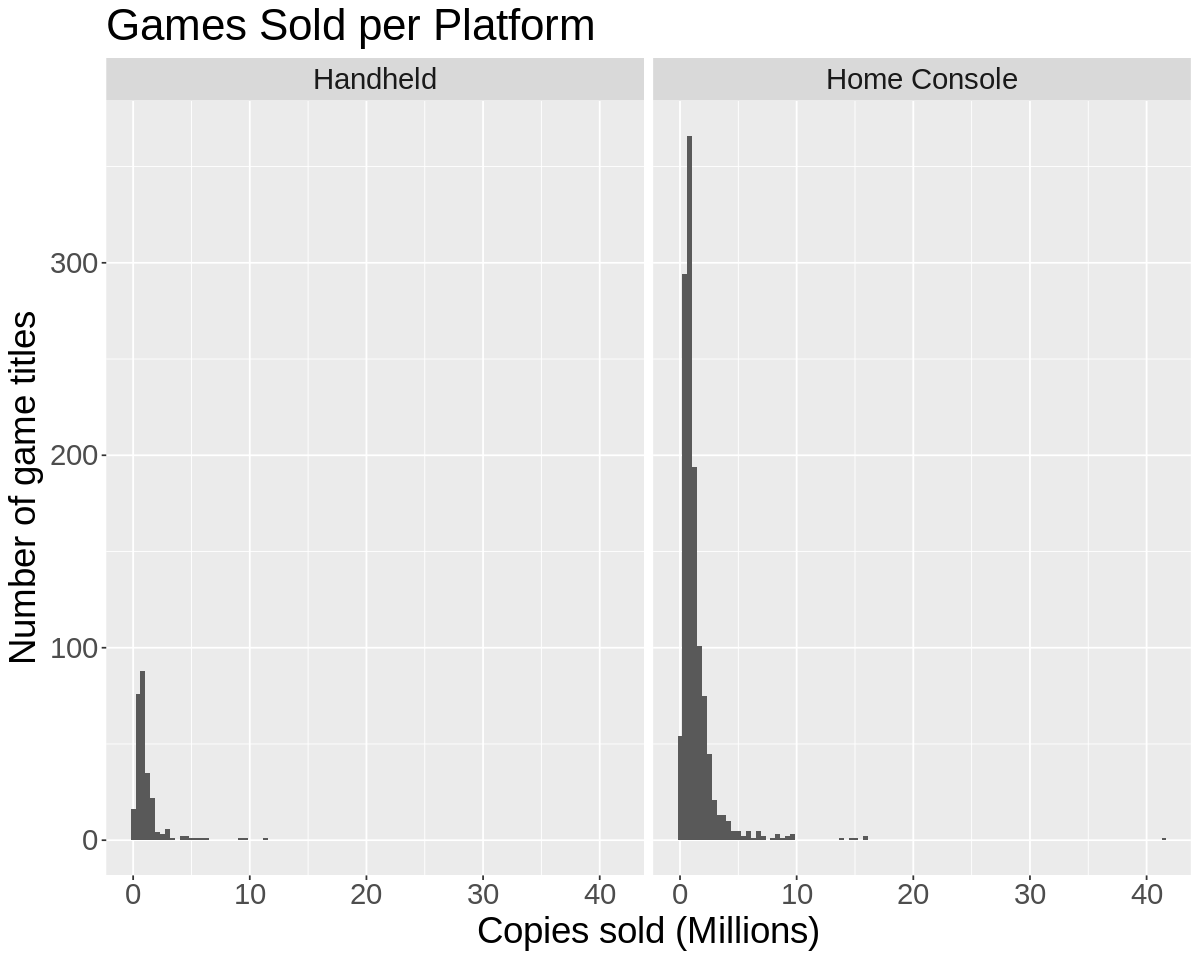

In [136]:
#Comparing the sampling distributions of handheld and home console systems in North America
gaming_data_dist_na <-
gaming_data %>%
ggplot() +
geom_histogram(aes(x = NA_Sales), bins = 100) +
facet_wrap(~ Platform) +
xlab("Copies sold (Millions)") +
ylab("Number of game titles") +
ggtitle("Games Sold per Platform")+
theme(text = element_text(size = 22))
gaming_data_dist_na

In [149]:
# Total sales
total_sales <-
    sum(gaming_data$Global_Sales)
total_titles <- NROW(gaming_data)
sum_stats <-
  gaming_data |>
  group_by(Platform) |>
  summarise(Num_Titles = n(),
            Titles_Proportion = Num_Titles/total_titles,
            Sales_Total = sum(Global_Sales),
            Sales_Proportion = Sales_Total/total_sales,
            Sales_Mean = mean(Global_Sales),
            Sales_SD = sd(Global_Sales,))

sum_stats


Platform,Num_Titles,Titles_Proportion,Sales_Total,Sales_Proportion,Sales_Mean,Sales_SD
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Handheld,262,0.175957,721.40,0.1755517,2.753435,3.693994
Home Console,1227,0.824043,3387.93,0.8244483,2.761149,3.745095


# Methods: Plan

This report is trustworthy as a large amount of data is being used (1489 observations), we have kept the data relatively current  (filtered the data so that the earliest year is 2001), and there is a variety of consoles (wii, xbox, playstation, etc.) and handheld devices (Gameboy, DS, Playstation Vita, etc.) included in the data  The plots and estimates we have provided thus far are not enough because, while it may give some idea of the differences, we cannot see whether these differences are significant or not.  In order to see whether the mean differences are significant,  we will complete a two-sided hypothesis test using bootstrapping. The null hypothesis being that there is no significant difference in means between handheld and home console sales in North America and the alternative being that there is a difference.  Further when we obtain our test statistic for the difference in means, we will obtain a 95% confidence interval using bootstrapping to see if the confidence interval contains 0 to confirm our hypothesis test results and check whether there is a meaningful difference or not.  Due to the popularity of console gaming in North America, we expect there will be a meaningful difference in the mean game sales with the mean sales of console video games being higher than that of handheld game, however we are still not confident enough to make our hypothesis test one-sided as we believe there is still a chance the mean difference may be meaningful in the other direction.  The impact of these findings is that it can give an idea of how popular console gaming is compared to hand-held gaming in North America and further it can give video game distributors in North America an idea of how large their respective markets are so they know what platforms they should make their video games available on in the future.  Future questions this could lead to are: Is the meaningful difference in mean video games sales due to specific consoles or handheld gaming devices?  Is this difference due to specific brands?  Is there a meaningful difference in the enjoyment level of console users versus handheld device users?


# References